In [ ]:
!pip install tqdm
!pip install openai==0.28
!pip install --upgrade gensim nltk pyLDAvis
!pip install spacy
!pip install wordcloud
!python -m spacy download en_core_web_sm



In [ ]:
# Importing necessary libraries

import csv
import datetime as date
import json
import os
import time
import statistics

import numpy as np
import pandas as pd
import requests
from collections import Counter

from urllib.parse import quote
from requests.exceptions import SSLError

import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser
import nltk
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import openai
import os
import time
import pandas as pd
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

In [ ]:
pip install lingua-language-detector

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.2/349.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 MB 12.3 MB/s eta 0:00:00


In [ ]:
import requests
import csv
import os
from urllib.parse import quote
from datetime import datetime, timedelta

# Function to fetch reviews
def get_reviews(appid, cursor="*"):
    cursor = quote(cursor)
    url = f"https://store.steampowered.com/appreviews/{appid}?json=1&filter={filter}&language={language}&day_range={day_range}&cursor={cursor}&review_type={review_type}&purchase_type={purchase_type}&num_per_page={num_per_page}"
    #print(f"Fetching URL for AppID {appid}: {url}")
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching reviews for AppID {appid}: {e}")
        return None

# Function to save reviews to a single CSV file
def save_reviews_to_csv(reviews, appid):
    file_name = "comments.csv"
    with open(file_name, "a", newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=['appid', 'review', 'date_created'])
        for review in reviews:
            # Convert the timestamp to mm/dd/yy format
            date_created = datetime.utcfromtimestamp(review['timestamp_created']).strftime('%m/%d/%y')
            writer.writerow({'appid': appid, 'review': review['review'], 'date_created': date_created})
    print(f"Saved reviews for AppID {appid} to comments.csv")

# Function to save games with no reviews
def save_no_reviews_list():
    with open("games_with_no_comments.csv", "w", newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=['appid', 'name'])
        writer.writeheader()
        writer.writerows(games_with_no_comments)
    print(f"Saved updated games with no comments to games_with_no_comments.csv")

# Process reviews for a single game
def process_game_reviews(appid):
    total_reviews = 0
    cursor = "*"
    game_reviews = []

    while total_reviews < max_reviews:
        data = get_reviews(appid, cursor)
        if data is None or 'reviews' not in data or not data['reviews']:
            print(f"No more reviews for AppID {appid}.")
            if total_reviews == 0:  # No reviews at all
                games_with_no_comments.append({'appid': appid, 'name': f"Game_{appid}"})  # Example name, replace with actual if available
                save_no_reviews_list()  # Save the no_reviews list after every addition
            break

        for review in data['reviews']:
            review_timestamp = datetime.utcfromtimestamp(review['timestamp_created'])

            # Check if review is older than 504 days
            if review_timestamp < cutoff_date:
                print(f"Reached the 504-day cutoff date for AppID {appid}.")
                continue  # Skip this review

            game_reviews.append(review)
            total_reviews += 1

            # If we hit 500 reviews, stop collecting
            if total_reviews >= max_reviews:
                print(f"Reached the limit of 500 reviews for AppID {appid}.")
                break

        # Update the cursor and continue if there are more reviews
        cursor = data['cursor']
        if cursor == "*":
            break

        if total_reviews < 100:  # Less than max, reached end of page
            print(f"Reached the end of page for AppID {appid}.")
            break

    if game_reviews:
        save_reviews_to_csv(game_reviews, appid)

# Function to check the last processed appid from the comments.csv file
def get_last_processed_appid():
    file_name = "comments.csv"
    if not os.path.exists(file_name):
        return None  # No file exists, so no appid has been processed yet

    with open(file_name, "r", newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        rows = list(reader)
        if rows:
            # Handle the .0 case by converting to a string first, then to an int safely
            appid_str = rows[-1]['appid']
            print(f"Last processed appid in comments.csv: {appid_str}")  # Debugging print
            return str(int(float(appid_str)))  # Return the last processed appid as string
    return None


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Convert appid_list from a Pandas Series to a list
appid_list = covid_ids.tolist()  # Make sure to convert it to a list
filter = 'all'
language = 'english'
day_range = 504  # Limit reviews to the past 504 days
review_type = 'all'
purchase_type = 'all'  # default is Steam
num_per_page = 100  # max reviews per page
max_reviews = 500  # Cap at 500 reviews
cutoff_date = datetime.now() - timedelta(days=504)  # 504 days ago

# Lists to store games with no comments
games_with_no_comments = []
total_games = len(appid_list)  # Total number of games to process
games_completed = 0  # Counter for number of games processed

# Debugging print to verify appid_list contents
print(f"AppID List: {appid_list[:10]}...")  # Printing first 10 appids for sanity check
print(f"Total Games: {total_games}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'covid_ids' is not defined

In [ ]:
# Start the script and resume from the last appid processed
last_processed_appid = get_last_processed_appid()

if last_processed_appid is not None:
    print(f"Resuming from appid {last_processed_appid}")
else:
    print("Starting fresh")

# Process each game in the appid list, skipping already processed ones
found_last_processed = last_processed_appid is None  # True if we start fresh

with open("comments.csv", "a", newline='', encoding='utf-8') as f:
    if last_processed_appid is None:
        writer = csv.DictWriter(f, fieldnames=['appid', 'review', 'date_created'])
        writer.writeheader()  # Write header for the CSV if starting fresh

for appid in appid_list:
    # Skip until we find the last processed appid
    if not found_last_processed:
        print(f"Comparing {appid} with {last_processed_appid}")  # Debugging print to verify comparison
        if int(appid) == int(last_processed_appid):
            found_last_processed = True  # Found it, start processing next one
        continue

    # Process this appid
    process_game_reviews(appid)
    games_completed += 1
    print(f"Completed {games_completed}/{total_games} games.\n")  # Show progress

print("Processing complete.")

In [ ]:
# load comments.csv:
comments_df = pd.read_csv('/content/drive/MyDrive/Dat490/Data/comments.csv')
print(comments_df.head())

# load no comments:
no_comments_df = pd.read_csv('/content/drive/MyDrive/Dat490/Data/games_with_no_comments.csv')
print(no_comments_df.head())


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Dat490/Data/comments.csv'

In [ ]:
# how many unique appid in comments:
print("Games with comments: ", comments_df['appid'].nunique())

#how many games in no_comments:
print("Games with no comments: ", no_comments_df['appid'].nunique())


In [ ]:
comments_df.head()

In [ ]:
import concurrent.futures
import pandas as pd
from lingua import LanguageDetectorBuilder
from tqdm import tqdm
import os

# Initialize language detector
detector = LanguageDetectorBuilder.from_all_languages().build()

# Function to detect language with error handling
def detect_language_safe(comment):
    if isinstance(comment, str):  # Only process if it's a string
        lang = detector.detect_language_of(comment)
        return lang.iso_code_639_1 if lang else 'unknown'
    return 'unknown'

# Multithreading with progress tracking
def multithreaded_language_detection(df, column_name='review', num_threads=4, chunk_size=10000, checkpoint_path='progress_checkpoint.csv'):
    total_rows = len(df)

    # Check if a checkpoint exists
    if os.path.exists(checkpoint_path):
        print("Resuming from checkpoint...")
        processed_df = pd.read_csv(checkpoint_path)
        start_idx = len(processed_df)  # Resume from where you left off
        df = df[start_idx:]  # Only process remaining rows
    else:
        processed_df = pd.DataFrame()
        start_idx = 0

    # Process the data in chunks
    for chunk_start in tqdm(range(0, total_rows, chunk_size), desc="Processing batches"):
        chunk_end = min(chunk_start + chunk_size, total_rows)
        df_chunk = df.iloc[chunk_start:chunk_end].copy()  # Copy to avoid SettingWithCopyWarning

        with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
            results = list(executor.map(detect_language_safe, df_chunk[column_name]))

        # Assign results to the DataFrame chunk using .loc
        df_chunk.loc[:, 'lang_detected'] = results

        # Append the processed chunk to the main DataFrame
        processed_df = pd.concat([processed_df, df_chunk], ignore_index=True)

        # Save checkpoint after each chunk
        processed_df.to_csv(checkpoint_path, index=False)


multithreaded_language_detection(comments_df, column_name='review', num_threads=1, chunk_size=10000, checkpoint_path='language_detection_progress.csv')


In [ ]:
# loading:
comments_df = pd.read_csv('/content/language_detection_progress.csv')


In [ ]:

# saving comment data:
comments_df.to_csv('/content/drive/MyDrive/Dat490/Data/comments.csv', index=False)

In [ ]:
comments_df.head()

In [ ]:
#strip "IsoCode639-1.":
comments_df['lang_detected'] = comments_df['lang_detected'].str.replace('IsoCode639_1.', '')

# lang_detected values:
print(comments_df['lang_detected'].value_counts())

In [ ]:
#print number of comments:
print("Number of comments: ", len(comments_df))

#print number of "english comments":
print("Number of English Comments: ", len(comments_df[comments_df['lang_detected'] == 'EN']))



#print number of "unknown":
print("Number of unknown: ", len(comments_df[comments_df['lang_detected'] == 'unknown']))

#print number of non EN or unknown:
print("Number of non EN or unknown: ", len(comments_df[(comments_df['lang_detected'] != 'EN') & (comments_df['lang_detected'] != 'unknown')]))



In [ ]:
# changing lang_detected to "Language":
comments_df.rename(columns={'lang_detected': 'Language'}, inplace=True)

In [ ]:
#top 10 languages detected bar chart:
comments_df['Language'].value_counts().head(10).plot(kind='bar')

In [ ]:
#df of non english languages, excluding unknown:
foreign_comments_df = comments_df[(comments_df['Language'] != 'EN') & (comments_df['Language'] != 'unknown')]

# bar chart of top 10 languages, titled: Top Non-English Comments:
# y-axis labeled "comments":
foreign_comments_df['Language'].value_counts().head(25).plot(kind='bar', title='Confusing Top Non-English Comments Identified by Lingua Py', ylabel='comments')


In [ ]:
foreign_comments_df.head()

In [ ]:
# table of top 10 languages, excluding unknown:
comments_df[comments_df['Language'] != 'unknown']['Language'].value_counts().head(100).to_frame()

In [ ]:
# tried and nix'd, we're throwing out non-english comments
#translate_comments_with_progress(foreign_comments_df)

In [ ]:
#en comments:
en_comments_df = comments_df[comments_df['Language'] == 'EN']

In [ ]:
en_comments_df.head()

In [ ]:
# saving en_comment_df:
en_comments_df.to_csv('/content/drive/MyDrive/Dat490/Data/en_comments.csv', index=False)

In [ ]:
# tried and nix'd, we're throwing out non-english comments
import openai
import os
import time
import pandas as pd
from tqdm import tqdm

openai.api_key = ### It's a secret ###

# Token limit settings
TOKENS_PER_MINUTE_LIMIT = 80000
TOKEN_USAGE = 0
LAST_RESET_TIME = time.time()

# File paths for checkpointing
INDEX_FILE = 'index.txt'
CHECKPOINT_FILE = 'partial_translations.csv'

# Function to track token usage
def track_token_usage(token_count):
    global TOKEN_USAGE, LAST_RESET_TIME
    current_time = time.time()

    if current_time - LAST_RESET_TIME > 60:
        TOKEN_USAGE = 0
        LAST_RESET_TIME = current_time

    if TOKEN_USAGE + token_count > TOKENS_PER_MINUTE_LIMIT:
        wait_time = 60 - (current_time - LAST_RESET_TIME)
        print(f"Token limit reached, waiting {wait_time:.2f} seconds...")
        time.sleep(wait_time)
        TOKEN_USAGE = 0
        LAST_RESET_TIME = time.time()

    TOKEN_USAGE += token_count

# Function to translate a comment using GPT-3.5-turbo
def translate_comment(text):
    prompt = f"Translate the following text to English: '{text}' (text may already be in English). Respond back in only this format: 'OG_lang | translation'."
    promp2 = f'I am going to give you inputs in JSON and you will output JSON. We are translating comments. Use the two letter ISO code to identify the original language. Reply in the format {"lang": "", "translation": ""}'

    while True:
        try:
            prompt_tokens = len(prompt.split())
            track_token_usage(prompt_tokens)

            # Make the OpenAI API request
            response = openai.ChatCompletion.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "system", "content": "You are a helpful assistant that translates text."},
                    {"role": "user", "content": prompt}
                ]
            )

            # Track tokens used by the response
            response_tokens = response['usage']['total_tokens']
            track_token_usage(response_tokens)

            return response['choices'][0]['message']['content'].strip()

        except openai.error.RateLimitError:
            time.sleep(10)  # Wait before retrying on rate limit error
        except Exception as e:
            return None

# Function to read the last processed index from index.txt
def get_last_processed_index():
    if os.path.exists(INDEX_FILE):
        with open(INDEX_FILE, 'r') as f:
            return int(f.read().strip())
    return 0

# Function to save the current index to index.txt
def save_current_index(idx):
    with open(INDEX_FILE, 'w') as f:
        f.write(str(idx))

# Function to process translations with checkpointing
def translate_comments_with_progress(df):
    # Load the last processed index
    start_idx = get_last_processed_index()
    print(f"Resuming from index {start_idx}")

    # If checkpoint exists, update DataFrame with saved progress
    if os.path.exists(CHECKPOINT_FILE):
        df_checkpoint = pd.read_csv(CHECKPOINT_FILE)
        df.update(df_checkpoint)

    # Iterate through comments from the last saved index
    for idx, row in tqdm(df.iloc[start_idx:].iterrows(), total=len(df) - start_idx, desc="Translating comments"):
        if pd.notnull(row['translated_comment']) and row['translated_comment'].strip() != "":
            continue  # Skip if already translated

        # Translate the comment
        translated_text = translate_comment(row['review'])
        if translated_text is not None:
            df.loc[idx + start_idx, 'translated_comment'] = translated_text
        else:
            print(f"Translation failed for row {idx + start_idx}")

        # Save progress every 1000 comments
        if (idx + start_idx + 1) % 1000 == 0:
            df.to_csv(CHECKPOINT_FILE, index=False)
            save_current_index(idx + start_idx + 1)
            print(f"Progress saved at index {idx + start_idx + 1}")

    # Save final result
    df.to_csv('translated_foreign_comments.csv', index=False)

In [ ]:
# loading in en_comments:
en_comments_df = pd.read_csv('/content/drive/MyDrive/Dat490/Data/en_comments.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#tag_df.to_csv('/content/drive/MyDrive/Dat490/Data/tag_count.csv', index=False)
# loading in tag_df:
tag_df = pd.read_csv('/content/drive/MyDrive/Dat490/Data/tag_count.csv')

#loading in genre_df:
genre_df = pd.read_csv('/content/drive/MyDrive/Dat490/Data/genre_count.csv')

#genre_df.to_csv('/content/drive/MyDrive/Dat490/Data/genre_count.csv', index = False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
tag_set = set(tag_df['tag'].unique())
genre_set = set(genre_df['genre'].unique())
game_features = tag_set.union(genre_set)

def count_game_feature_mentions(tokens, game_features):
    mentions = {feature: 0 for feature in game_features}
    for token in tokens:
        if token in game_features:
            mentions[token] += 1
    return mentions

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
en_comments_df.sample(10)

In [ ]:
# Install necessary libraries
print("Installing libraries...")
!pip install --upgrade gensim nltk pyLDAvis
!pip install spacy
!pip install wordcloud
!python -m spacy download en_core_web_sm

# Import libraries
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser
import nltk
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Setup
print("Setting up...")
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Define important short words to retain
important_short_words = {'ai', 'xp', 'gg', 'hp', 'mp', 'rp', 'bt', 'cd', 'dc', 'ks'}

# Ensure DataFrame is loaded
try:
    en_comments_df
except NameError:
    raise NameError("DataFrame 'en_comments_df' is not loaded. Please load your DataFrame before running the script.")

# Preprocessing function
def preprocess_text(text, min_length=3, exceptions=None):
    if exceptions is None:
        exceptions = set()
    tokens = simple_preprocess(str(text), deacc=True)
    tokens = [token for token in tokens if token not in stop_words and (len(token) >= min_length or token in exceptions)]
    return tokens

# Apply preprocessing with a single progress bar
print("Tokenizing and cleaning reviews...")
en_comments_df['tokens'] = [preprocess_text(review, min_length=3, exceptions=important_short_words) for review in tqdm(en_comments_df['review'], desc="Processing", leave=False)]

# Create bigram and trigram models
print("Creating bigram and trigram models...")
bigram = Phrases(en_comments_df['tokens'], min_count=5, threshold=100)
trigram = Phrases(bigram[en_comments_df['tokens']], threshold=100)
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# Apply bigrams and trigrams with a single progress bar
from tqdm import tqdm
tqdm.pandas()

print("Applying bigrams and trigrams...")
en_comments_df['bigrams'] = [bigram_mod[tokens] for tokens in tqdm(en_comments_df['tokens'], desc="Bigrams", leave=False)]
en_comments_df['trigrams'] = [trigram_mod[tokens] for tokens in tqdm(en_comments_df['bigrams'], desc="Trigrams", leave=False)]

# Combine unigrams, bigrams, and trigrams
print("Combining unigrams and bigrams/trigrams...")
en_comments_df['final_tokens'] = en_comments_df['trigrams']

# Display a sample to verify (suppressing the automatic display of large DataFrame outputs)
print("Sample of preprocessed data:")
sample_output = en_comments_df[['review', 'final_tokens']].head()
print(sample_output.to_string(index=False))

In [ ]:
# save the processed df:
#en_comments_df.to_csv('/content/drive/MyDrive/Dat490/Data/en_comments_processed.csv', index=False)

# load processed comments:
en_comments_df = pd.read_csv('/content/drive/MyDrive/Dat490/Data/en_comments_processed.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Check for missing values in 'tokens' and 'final_tokens'
print("Missing values in 'tokens':", en_comments_df['tokens'].isnull().sum())
print("Missing values in 'final_tokens':", en_comments_df['final_tokens'].isnull().sum())

# Check for empty lists
empty_tokens = en_comments_df['tokens'].apply(len) == 0
empty_final_tokens = en_comments_df['final_tokens'].apply(len) == 0
print("Empty 'tokens' lists:", empty_tokens.sum())
print("Empty 'final_tokens' lists:", empty_final_tokens.sum())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Missing values in 'tokens': 0
Missing values in 'final_tokens': 0
Empty 'tokens' lists: 0
Empty 'final_tokens' lists: 0


In [ ]:
# Check for missing values in 'final_tokens'
missing_tokens = en_comments_df['final_tokens'].isnull().sum()
print(f"Missing 'final_tokens': {missing_tokens}")

# Check for empty token lists
empty_tokens = en_comments_df['final_tokens'].apply(len) == 0
print(f"Empty 'final_tokens' lists: {empty_tokens.sum()}")

Missing 'final_tokens': 0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Empty 'final_tokens' lists: 0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Basic Statistics of Token Counts:
count    648481.000000
mean        472.757905
std         751.884708
min           2.000000
25%         103.000000
50%         229.000000
75%         505.000000
max       10639.000000
Name: token_count, dtype: float64


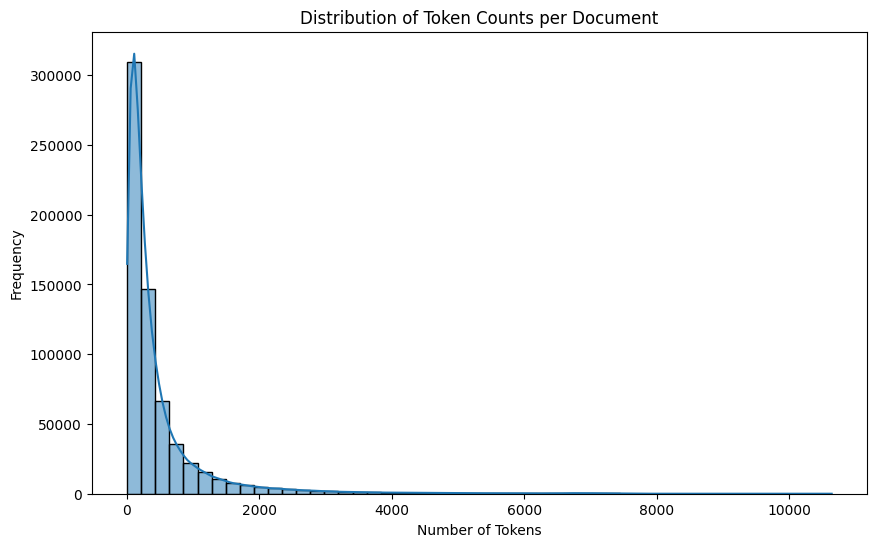

In [ ]:
# Number of tokens per document
en_comments_df['token_count'] = en_comments_df['final_tokens'].apply(len)

# Basic statistics
print("Basic Statistics of Token Counts:")
print(en_comments_df['token_count'].describe())

# Plot distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(en_comments_df['token_count'], bins=50, kde=True)
plt.title('Distribution of Token Counts per Document')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Inspect the first few entries of final_tokens to understand its structure
print(en_comments_df['final_tokens'].head(5))

# Check the type and structure of entries in 'final_tokens'
print("Inspecting the first 5 entries in 'final_tokens':")
for i, entry in enumerate(en_comments_df['final_tokens'].head(5)):
    print(f"Entry {i}: Type - {type(entry)}, Content - {entry}")

0    ['review', 'autoclick', 'works', 'wish', 'like...
1    ['refuses', 'start', 'without', 'downloading',...
2    ['awesome', 'auto_clicker', 'way', 'assemble',...
3    ['really', 'like', 'thanks', 'making', 'availa...
4    ['beginning', 'thought', 'program', 'would', '...
Name: final_tokens, dtype: object
Inspecting the first 5 entries in 'final_tokens':
Entry 0: Type - <class 'str'>, Content - ['review', 'autoclick', 'works', 'wish', 'like', 'dual', 'mouse_cursor', 'option', 'afking', 'click', 'another', 'screen', 'multitask', 'mouse_cursor', 'update', 'review', 'sometime', 'buying', 'support', 'dev', 'updated', 'review', 'move', 'cursor', 'multitask', 'using', 'dual', 'monitor', 'works', 'without', 'interrupting', 'tasks']
Entry 1: Type - <class 'str'>, Content - ['refuses', 'start', 'without', 'downloading', 'third', 'party', 'software', 'also', 'refuses', 'send', 'working', 'link', 'download', 'third', 'party', 'program']
Entry 2: Type - <class 'str'>, Content - ['awesome', 'auto

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import ast
from collections import Counter

# Step 1: Convert each entry in 'final_tokens' from a string to a list using `ast.literal_eval`
en_comments_df['final_tokens'] = en_comments_df['final_tokens'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Step 2: Flatten the list of tokens from 'final_tokens'
all_tokens = [token for tokens_list in en_comments_df['final_tokens'] for token in tokens_list]

# Step 3: Count the frequency of each token
token_freq = Counter(all_tokens)

# Step 4: Get the 200 most common tokens/phrases
common_tokens = token_freq.most_common(500)

# Step 5: Print the top 200 most common tokens/phrases
print("\nTop 200 Most Common Tokens/Phrases:")
for token, freq in common_tokens:
    print(f"{token}: {freq}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Top 200 Most Common Tokens/Phrases:
game: 1257349
like: 350560
fun: 222379
good: 211868
really: 207368
get: 196208
one: 192762
play: 185173
time: 175717
games: 169765
great: 147198
would: 146578
even: 142443
also: 135225
much: 124606
story: 124252
well: 108919
lot: 106530
first: 105471
make: 100991
still: 100985
love: 100293
way: 98015
gameplay: 94223
see: 93195
feel: 89225
new: 88151
playing: 87009
recommend: 85166
played: 81356
could: 80546
little: 80101
hours: 78540
think: 78350
want: 76680
bit: 76614
better: 75364
things: 73358
pretty: 73229
feels: 69079
every: 67172
many: 66952
experience: 65612
worth: 64532
need: 63905
different: 63363
characters: 63239
far: 60759
level: 59898
back: 59595
something: 59371
people: 57674
made: 56149
got: 55958
find: 55200
around: 55140
nice: 54939
best: 54641
bad: 54472
character: 54281
work: 54210
combat: 54119
enough: 53213
overall: 52389
say: 52342
though: 52327
world: 50946
know: 50657
right: 50420
going: 50379
hard: 50051
use: 48260
give: 478

In [ ]:
# Extract bigrams and trigrams (tokens with '_')
bigram_trigram_tokens = [token for token in all_tokens if '_' in token]

# Count frequency
bigram_trigram_freq = Counter(bigram_trigram_tokens)

# Top 50
common_bigrams_trigrams = bigram_trigram_freq.most_common(500)
print("\nTop 50 Most Common Bigrams/Trigrams:")
for token, freq in common_bigrams_trigrams:
    print(f"{token}: {freq}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Top 50 Most Common Bigrams/Trigrams:
early_access: 35052
voice_acting: 9696
current_state: 6816
pixel_art: 5069
old_school: 3986
boss_fights: 3854
tower_defense: 3765
fast_paced: 3698
visual_novel: 3654
replay_value: 3423
price_tag: 3411
sound_effects: 3410
years_ago: 3346
vampire_survivors: 3344
jump_scares: 3128
https_steamcommunity: 2820
city_builder: 2763
store_steampowered_com_curator: 2722
bullet_hell: 2664
com_sharedfiles_filedetails: 2660
learning_curve: 2547
https_youtu: 2521
skill_tree: 2147
meta_progression: 2130
attention_detail: 2039
url_https_store_steampowered: 1982
top_notch: 1796
slay_spire: 1785
cut_scenes: 1783
stardew_valley: 1775
resource_management: 1772
dark_souls: 1762
fast_travel: 1731
hidden_gem: 1696
https_www_youtube_com: 1687
power_ups: 1666
rogue_lite: 1510
replay_ability: 1480
bare_bones: 1447
hidden_object: 1427
hollow_knight: 1424
url_url_https: 1360
pay_attention: 1342
cash_grab: 1322
store_page: 1304
walking_simulator: 1292
trial_error: 1286
forget_r

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


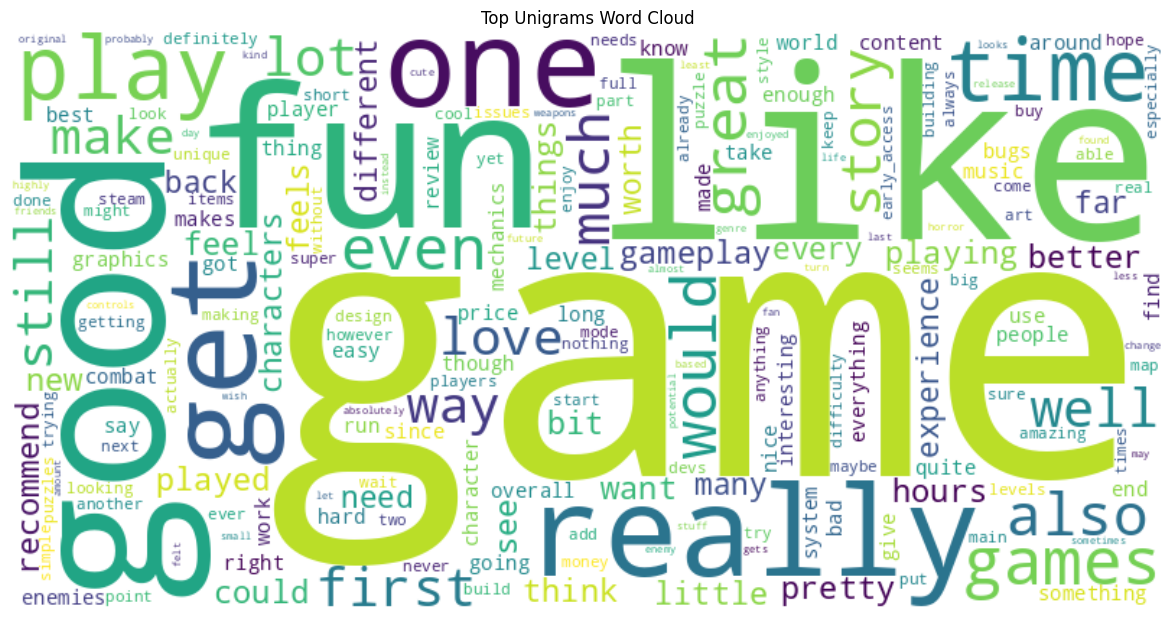

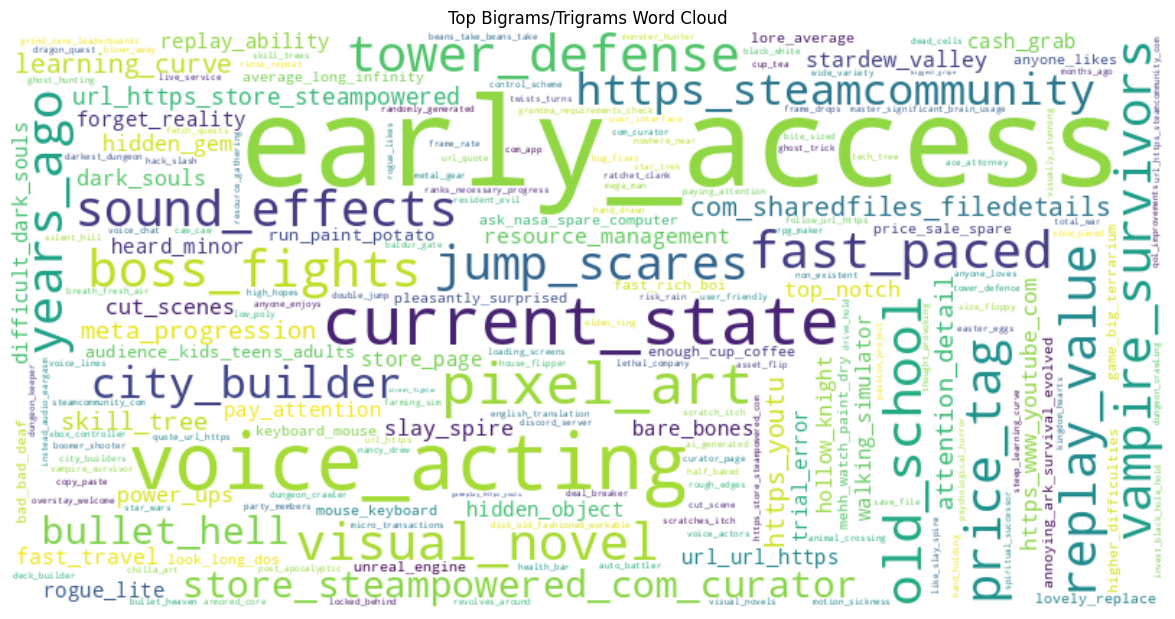

In [ ]:
from wordcloud import WordCloud

# Word cloud for unigrams
wordcloud_unigram = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(token_freq)

plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud_unigram, interpolation='bilinear')
plt.axis('off')
plt.title('Top Unigrams Word Cloud')
plt.show()

# Word cloud for bigrams/trigrams
wordcloud_bigram_trigram = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_trigram_freq)

plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud_bigram_trigram, interpolation='bilinear')
plt.axis('off')
plt.title('Top Bigrams/Trigrams Word Cloud')
plt.show()

In [ ]:
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Step 1: Create a Dictionary from the 'final_tokens'
dictionary = Dictionary(en_comments_df['final_tokens'])

# Step 2: Filter extremes to remove very common and very rare tokens
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# Step 3: Create a Bag-of-Words Corpus
corpus = [dictionary.doc2bow(tokens) for tokens in en_comments_df['final_tokens']]

Streaming output truncated to the last 5000 lines.
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/usr/local/lib/python3.10/dist-packages/gensim/models/ldamulticore.py", line 341, in worker_e_step
    chunk_no, chunk, w_state = input_queue.get()
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 104, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
Process ForkPoolWorker-736:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/po

# Do only one of these two:

In [ ]:
import gc
gc.collect()
del corpus_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'corpus_df' is not defined

In [ ]:
# Shortest viable test run to confirm the LDA setup works
num_topics_test = 5  # Minimal number of topics for a very quick test
lda_model_test = LdaMulticore(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics_test,  # Minimal number of topics
    random_state=100,
    chunksize=200,  # Small chunk size for memory efficiency
    passes=1,       # Single pass for speed
    iterations=10,  # Minimal iterations
    per_word_topics=True,
    workers=1       # Set to 1 for Colab free tier
)

In [ ]:
# longer run, will take a long time ~10 to 30 mins

# Step 4: Build the LDA Model
num_topics = 25  # Adjust the number of topics as needed
lda_model = LdaMulticore(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,6
    random_state=100,
    chunksize=200,
    passes=10,
    iterations=100,
    per_word_topics=True,
    workers=2  # Use multiple cores for processing
)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Step 5: Print the Topicscha
print("\nLDA Model Topics:")
for idx, topic in lda_model.print_topics(num_topics=num_topics, num_words=15):
    print(f"Topic {idx + 1}: {topic}")


# Step 6: Visualize the Topics (optional)
print("\nPreparing LDA Visualization...")
lda_visualization = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_visualization)

# Save the visualization to an HTML file if needed
# pyLDAvis.save_html(lda_visualization, 'lda_visualization.html')

In [ ]:
lda_topics_df = pd.read_csv('/content/drive/MyDrive/Dat490/Data/LDA renamed.csv')
en_comments_df = pd.read_csv('/content/drive/MyDrive/Dat490/Data/en_comments_processed.csv')

import re

# Step 1: Extract keywords for each topic
lda_topics = {}
for _, row in lda_topics_df.iterrows():
    topic_name = row['Renamed']  # Use the column name directly without renaming

    # Ensure the content is a string before processing
    if isinstance(row['content'], str):
        # Extract all words between double quotes using regex
        keywords = re.findall(r'"(.*?)"', row['content'])
        lda_topics[topic_name] = keywords

# Step 2: Create a function to assign LDA topics to comments
def assign_lda_topics(comment):
    comment = comment.lower()  # Convert to lowercase to ensure case-insensitive matching
    topics_found = []
    for topic, keywords in lda_topics.items():
        if any(keyword in comment for keyword in keywords):
            topics_found.append(topic)
    return topics_found

In [ ]:
en_comments_df.sample()

In [ ]:
# Step 3: Apply the function to `en_comments_processed` to create a new column for LDA topics
en_comments_df['lda_topics'] = en_comments_df['review'].apply(assign_lda_topics)

# Step 4: Summarize LDA topics per game (appid)
# Explode the 'lda_topics' list to create a row for each topic per comment
topics_exploded = en_comments_df.explode('lda_topics')

# Drop rows where 'lda_topics' is empty (no topic matched)
topics_exploded = topics_exploded.dropna(subset=['lda_topics'])

# Count the occurrences of each topic per game
topic_counts_per_game = topics_exploded.groupby(['appid', 'lda_topics']).size().reset_index(name='count')

# Get the top 10 topics per game
top_10_topics_per_game = topic_counts_per_game.groupby('appid').apply(
    lambda x: x.nlargest(10, 'count')
).reset_index(drop=True)

# Step 5: Aggregate the top topics into a list for each appid
top_topics_per_game = top_10_topics_per_game.groupby('appid')['lda_topics'].apply(list).reset_index()

In [ ]:
top_topics_per_game
#saving as csv:
top_topics_per_game.to_csv('/content/drive/MyDrive/Dat490/Data/top_topics_per_game.csv', index=False)

In [ ]:
# Check the structure of top_topics_per_game
print("Top Topics per Game:")
print(top_topics_per_game.head(10))

# Check the structure of features_df
print("\nFeatures DataFrame:")
print(features_df.head(10))

# Check the type of 'all_features' in both DataFrames
print("\nData type of 'all_features' in top_topics_per_game:")
print(type(top_topics_per_game['lda_topics'].iloc[0]))

print("\nData type of 'all_features' in features_df:")
print(type(features_df['all_features'].iloc[0]))